# Composition Effects in Judicial Panels

In [1]:
using Model
using Dictionaries, SplitApplyCombine
using DataFramesMeta, Dates
using CairoMakie
using StatsBase

In [2]:
decisions = Model.loaddata("../data/processed/json_augmented");

##### What do we really want to know?

- are there composition effects which go beyond the 'sum of parts'?
- Do boards' decisions change systematically when a new judge enters (an old judge exits)?


##### What we need to know before
- How frequent are changes to the board composition?


In [40]:
decisions_from_board(decisions, board) = filter(d -> id(senate(d)) == board, decisions)

decisions_from_board (generic function with 1 method)

In [41]:
compositions(ds; num_judges=5) = map(js -> Set(label.(first(js, num_judges))), judges.(ds))

compositions (generic function with 1 method)

In [42]:
function find_composition_changes(decisions; num_judges=5)
    changes = Date[]
    getjudgeids(d) = Set(id.(first(judges(d), num_judges)))
    current_comp = getjudgeids(first(decisions))
    for d in decisions[2:end]
        js = getjudgeids(d)
        if js != current_comp
            push!(changes, date(d))
            current_comp = js
        end
    end
    changes
end

find_composition_changes (generic function with 1 method)

In [43]:
function plot_dates!(ax, ds; kwargs...)
    x = datetime2rata.(ds)
    xticks=(datetime2rata.(Date.(2000:5:2020)), string.(2000:5:2020))
    vlines!(ax, x; color=(:midnightblue, :0.9), kwargs...)
    ax.xticks = xticks
    hideydecorations!(ax)
    return
end
function plot_dates(ds)
    fig = Figure(resolution=(800, 100))
    ax = Axis(fig[1,1])
    plot_dates!(ax, ds)
    fig
end

plot_dates (generic function with 1 method)

In [44]:
function plot_boards(decisions; boards=1:7, plotchanges=false, num_judges=5)
    fig = Figure()
    for (i, board) in enumerate(boards)
        Label(fig[i, 1], "Board $board")
        ax = Axis(fig[i, 2]; xgridvisible=false)
        ds = decisions_from_board(decisions, board)
        plot_dates!(ax, date.(ds))
        
        if plotchanges
            cs = find_composition_changes(ds; num_judges)
            plot_dates!(ax, cs; color=(:crimson, 0.9))
        end

        xlims!(ax, datetime2rata.((Date(1999), Date(2022))))
        i != length(boards) && hidexdecorations!(ax)
    end
    resize_to_layout!(fig)
    fig
end

plot_boards (generic function with 1 method)

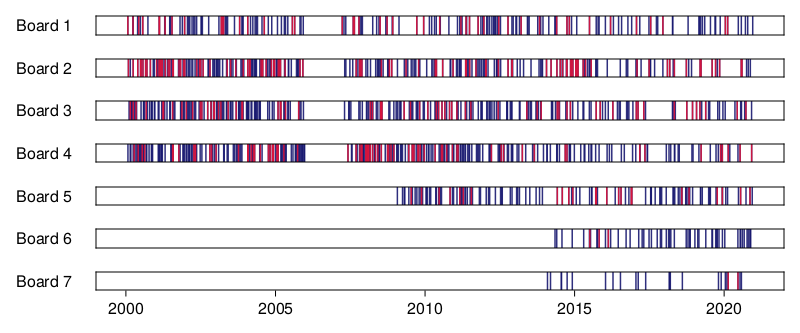

In [51]:
plot_boards(decisions; plotchanges=true, num_judges=1)

In [46]:
let board = 3
    ds = decisions_from_board(decisions, board)
    println("Board $board ($(length(ds)) cases)")
    foreach(1:5) do k
        c = compositions(ds; num_judges=k) |> unique
        println("   Number of unique $k-compositions: $(length(c))")
    end
end

Board 3 (264 cases)
   Number of unique 1-compositions: 12
   Number of unique 2-compositions: 68
   Number of unique 3-compositions: 110
   Number of unique 4-compositions: 145
   Number of unique 5-compositions: 155


In [47]:
let ds = decisions
    c = compositions(ds; num_judges=1)
    sort!(StatsBase.countmap(c) |> Dictionary; rev=true)
end;

## Apply Method from Allison & Lemley, 2000

In [22]:
using HypothesisTests
using Dictionaries, SplitApplyCombine

In [38]:
X = map(group(id ∘ first ∘ judges, decisions)) do ds
    partial  = count(==("partially annulled"), label.(outcome.(ds)))
    annulled = count(==("annulled"), label.(outcome.(ds)))
    rejected = count(==("claim dismissed"), label.(outcome.(ds)))
    (;annulled, partial, rejected)
end |> DataFrame |> Matrix;

In [56]:
test = ChisqTest(X)
pvalue(test)

2.926701710648529e-5